In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.fft import fft2, ifft2
import scipy.io as spio
import time
from scipy.fft import rfft2, irfft2
from scipy.interpolate import RectBivariateSpline
from matplotlib.animation import FuncAnimation
import time

In [2]:
def NavSto2D_solve(z_init,nu, Nx, Tend, dt, Nout,al):
    '''
    This function solves the incompressible viscous 2D Navier Stokes equations 
    using pseudo-spectral method on doubly period domain
    === INPUTS ===
    z_init : initial condition for vorticity field
    nu : viscosit coefficient
    Nx : number of grid points in x (and y) direction(s). Total number of points Nx*Nx
    Tend : the length of time for which the simulation is performed
    dt : time step (if the solution blows up make this smaller)
    Nout : number of times the vorticity field is returned as an output 
            These outputs are equally spaced in time from time 0 to Tend
            
    === OUTPUTS ===
    zeta(Nx,Nx,Nout): vorticity field at different time derived from solving the PDE (Navier Stokes)
    
    '''    
    #  1) in Real Space
    Ny = Nx
    # grid spacing in real space
    dx = 2*np.pi/Nx
    dy = 2*np.pi/Ny
    # grid points in real space
    x = (np.arange(0,Nx))*dx
    y = (np.arange(0,Ny))*dy
    # meshgrid of the points
    xx, yy = np.meshgrid(x,y)
    #  padding xx and yy only for interpolation (according to periodic BC)
    #  See the side note 2) at the beginning of the script
    x_padd = (np.arange(0,Nx+1))*dx
    y_padd = (np.arange(0,Ny+1))*dy
    xx_padd, yy_padd = np.meshgrid(x_padd,y_padd)
    
    Nt = int(np.floor(Tend/dt))               # number of steps in time
    Nevery = int(np.ceil(Nt/Nout))            # every Nevery step the vorticity field is save for output
    Nout = int(Nt/Nevery)
    # ++++++++++ forming spectral coordinates ++++++++++
    Kx = np. zeros (Nx)
    Kx [: int(Nx /2)] = np. arange ( int(Nx /2))
    Kx[ int(Nx /2) :] = np. arange (- int(Nx /2) ,0)
    Ky = np. zeros (Nx)
    Ky [: int(Nx /2)] = np. arange ( int(Nx /2))
    Ky[ int(Nx /2) :] = np. arange (- int(Nx /2) ,0)
    Kxx , Kyy = np. meshgrid (Kx ,Ky)
    #Kxx = Kxx [: ,: Nx //2+1]                  #Floor division, rounds off to the nearest whole number. (//)
    #Kyy = Kyy [: ,: Nx //2+1]
    # ++++++++++ calculating operators used in time loop ++++++++++
    # this helps the code to be faster
    # and avoid unncessary computation inside the time loop
    # >>> calculating spectral operators <<<
    k2poisson = Kxx**2 + Kyy**2
    k2poisson[0, 0] = 1
    ikx_k2 = 1j*Kxx / k2poisson
    iky_k2 = 1j*Kyy / k2poisson
    # de-aliasing mask: forces the nonlinear terms for kx,ky>2/3 to be zero
    # depending on the problem and the type of dissipation can be relaxed ...
    L = np.ones(np.shape(k2poisson))
    for i in range(np.shape(k2poisson)[1]):
        for j in range(np.shape(k2poisson)[0]):
            if (abs(Kxx[j, i]) > max(Kx)*8./9.):
                L[j, i] = 0
            elif (abs(Kyy[j, i]) > max(Ky)*8./9.):
                L[j, i] = 0
    def interp_fft(x_padd, y_padd, qr, X_in, Y_in): 
        Q_padd = np.zeros((qr.shape[0]+1,qr.shape[1]+1))
        Q_padd[0:-1,0:-1] = qr
        Q_padd[-1,:] = Q_padd[0,:]
        Q_padd[:,-1] = Q_padd[:,0]
        interp_f = RectBivariateSpline(y_padd, x_padd, Q_padd, kx=3, ky=3)
        qr_interp = interp_f.ev(np.ravel(Y_in), np.ravel(X_in))
        qr_interp = np.reshape(qr_interp, (qr.shape[0], qr.shape[1]))
        return fft2(qr_interp)
    
    #Initial conditions are defined here:
    

    zk = fft2(z_init)
    ur = np.real(ifft2(iky_k2*zk))
    vr = np.real(ifft2(-ikx_k2*zk))

    uk = fft2(ur)
    vk = fft2(vr)
    #z_EMr = zr
    z_LMk = zk   # Lagrange mean initial
    z_LMk1 = zk
    Xixr = np.zeros(xx.shape)
    Xixr = np.zeros(xx.shape)
    Xiyr = np.zeros(yy.shape)
    Xixk = np.zeros(Kxx.shape)
    Xiyk = np.zeros(Kyy.shape)
    X_in = xx
    Y_in = yy
    uL_RHSk = uk;
    vL_RHSk = vk;
    zL_RHSk = zk;         #zL_RHS = α[z(x + \xi) - z_LMk]
    

    c_visc = np.exp(-nu*dt*(Kxx**2+Kyy**2))
    
    '''
        calculate the RHS of momentum eq written for vorticity & displacement for LM-velcocity 
        (RHS: everything but time derivative) 
    '''
    
    def RHS1(X):

        Xixr = np.real(ifft2(X[0]))
        Xiyr = np.real(ifft2(X[1]))
        #For rhs of Xi:
        Xix_xr = np.real(ifft2(1j * Kxx * X[0]))
        Xix_yr = np.real(ifft2(1j * Kyy * X[0]))
        Xiy_xr = np.real(ifft2(1j * Kxx * X[1]))
        Xiy_yr = np.real(ifft2(1j * Kyy * X[1]))
        # nonlinear terms in the \xi equation
        NXix = L * fft2(Xixr * Xix_xr + Xiyr * Xix_yr)
        NXiy = L * fft2(Xixr * Xiy_xr + Xiyr * Xiy_yr)
        xix = ((-NXix - X[0])*al + uL_RHSk)            #x and y components of displacement respectively
        xiy= ((-NXiy - X[1])*al + vL_RHSk)
        #print(xix)
        #Rhs of vorticity:
        z_LM_xr = np.real(ifft2(1j * Kxx * X[2]))
        z_LM_yr = np.real(ifft2(1j * Kyy * X[2]))
        NzL =  (Xixr * z_LM_xr + Xiyr * z_LM_yr)
        f1 = al*(zL_RHSk - X[2] - L*fft2(NzL))
        X1 = [xix,xiy,f1]
        return X1             #Fourier Transform
    
    '''
        calculate the RHS of momentum eq written for vorticity & displacement for 
        projection of LM-velcocity to a div-free velocity field. 
        (RHS: everything but time derivative) 
    '''
    
    def RHS2(X):

        udfxr = np.real(ifft2(X[0]))
        udfyr = np.real(ifft2(X[1]))
        #For rhs of Xi:
        Xix_xr = np.real(ifft2(1j * Kxx * Xixk))
        Xix_yr = np.real(ifft2(1j * Kyy * Xixk))
        Xiy_xr = np.real(ifft2(1j * Kxx * Xiyk))
        Xiy_yr = np.real(ifft2(1j * Kyy * Xiyk))
        # nonlinear terms in the \xi equation
        NXix = L * fft2(udfxr * Xix_xr + udfyr * Xix_yr)
        NXiy = L * fft2(udfxr * Xiy_xr + udfyr * Xiy_yr)
        udfx = ((-NXix - X[0]) + uL_RHSk)            #x and y components of displacement respectively
        udfy= ((-NXiy - X[1]) + vL_RHSk)
        #print(xix)
        #Rhs of vorticity:
        z_LM_xr = np.real(ifft2(1j * Kxx * X[2]))
        z_LM_yr = np.real(ifft2(1j * Kyy * X[2]))
        NzL =  (udfxr * z_LM_xr + udfyr * z_LM_yr)
        f1 = al*(zL_RHSk - X[2]) - L*fft2(NzL)
        X1 = [udfx,udfy,f1]
        return X1  
    
    #calculate the RHS of momentum eq written for vorticity 
    #(RHS: everything but time derivative)
    
    def RHS(zk):
        '''
        calculate the RHS of momentum eq written for vorticity 
        (RHS: everything but time derivative)
        '''
        ur = np.real(ifft2(iky_k2*zk))
        z_xr = np.real(ifft2(1j*Kxx*zk))
        vr = np.real(ifft2(-ikx_k2*zk))
        z_yr = np.real(ifft2(1j*Kyy*zk))
        nlr = ur*z_xr + vr*z_yr        
        return -L*fft2(nlr)             #Fourier Transform
    
    #User defined function to execute Rk4 method: 
    def Rk41(X):
        X0,X1,X2= 0,0,0
        KK1z = RHS2(X)
     
        KK1z[0] = KK1z[0]*(dt/2)
        KK1z[1] = KK1z[1]*(dt/2)
        KK1z[2] = KK1z[2]*(dt/2)
        
        KK2z = RHS2(X + KK1z)    
        KK2z[0] = KK2z[0]*(dt/2)
        KK2z[1] = KK2z[1]*(dt/2)
        KK2z[2] = KK2z[2]*(dt/2)
        
        KK3z = RHS2(X + KK2z)
        
        KK3z[0] = KK3z[0]*(dt)
        KK3z[1] = KK3z[1]*(dt)
        KK3z[2] = KK3z[2]*(dt)
        
        KK4z = RHS2(X + KK3z)
       
        KK1z[0] = KK1z[0]*(dt/6)
        KK1z[1] = KK1z[1]*(dt/6)
        KK1z[2] = KK1z[2]*(dt/6)
        
        KK2z[0] = KK2z[0]*(2*dt/6)
        KK2z[1] = KK2z[1]*(2*dt/6)
        KK2z[2] = KK2z[2]*(2*dt/6)
        
        KK3z[0] = KK3z[0]*(2*dt/6)
        KK3z[1] = KK3z[1]*(2*dt/6)
        KK3z[2] = KK3z[2]*(2*dt/6)
        
        KK4z[0] = KK4z[0]*(dt/6)
        KK4z[1] = KK4z[1]*(dt/6)
        KK4z[2] = KK4z[2]*(dt/6)
        
        X0 = X[0] + KK1z[0] + KK2z[0] + KK3z[0] + KK4z[0]
        X1 = X[1] + KK1z[1] + KK2z[1] + KK3z[1] + KK4z[1]
        X2 = X[2] + KK1z[2] + KK2z[2] + KK3z[2] + KK4z[2]
                
        return X0,X1,X2
    
    #User defined function to execute Rk4 method: 
    def Rk4(X):
        X0,X1,X2= 0,0,0
        KK1z = RHS1(X)
     
        KK1z[0] = KK1z[0]*(dt/2)
        KK1z[1] = KK1z[1]*(dt/2)
        KK1z[2] = KK1z[2]*(dt/2)
        
        KK2z = RHS1(X + KK1z)
       
        KK2z[0] = KK2z[0]*(dt/2)
        KK2z[1] = KK2z[1]*(dt/2)
        KK2z[2] = KK2z[2]*(dt/2)
        
        KK3z = RHS1(X + KK2z)
        
        KK3z[0] = KK3z[0]*(dt)
        KK3z[1] = KK3z[1]*(dt)
        KK3z[2] = KK3z[2]*(dt)
        
        KK4z = RHS1(X + KK3z)
       
        KK1z[0] = KK1z[0]*(dt/6)
        KK1z[1] = KK1z[1]*(dt/6)
        KK1z[2] = KK1z[2]*(dt/6)
        
        KK2z[0] = KK2z[0]*(2*dt/6)
        KK2z[1] = KK2z[1]*(2*dt/6)
        KK2z[2] = KK2z[2]*(2*dt/6)
        
        KK3z[0] = KK3z[0]*(2*dt/6)
        KK3z[1] = KK3z[1]*(2*dt/6)
        KK3z[2] = KK3z[2]*(2*dt/6)
        
        KK4z[0] = KK4z[0]*(dt/6)
        KK4z[1] = KK4z[1]*(dt/6)
        KK4z[2] = KK4z[2]*(dt/6)
        
        X0 = X[0] + KK1z[0] + KK2z[0] + KK3z[0] + KK4z[0]
        X1 = X[1] + KK1z[1] + KK2z[1] + KK3z[1] + KK4z[1]
        X2 = X[2] + KK1z[2] + KK2z[2] + KK3z[2] + KK4z[2]
                
        return X0,X1,X2
    
    '''
    Pseudo-momentum
    '''
    def pseudo():
        #vs_1 = Xixr*al - ur/t     #stokes drift
        #vs_2 = Xixr*al - vr/t
        
        #Second curl term in formula from O.Buhler for pseudo-momentum
        #uk_diff = [uk - uk/t,vk - vk/t]
        #zk_per = 1j * Kxx * uk_diff[1] - 1j * Kyy * uk_diff[0]         #curl of perturbation velocity
        
        #zk_perx_k = ikx_k2*zk_per
        #zk_pery_k = iky_k2*zk_per
        
        #uk_per = iky_k2*zk_per           #vector component of curl of perturbation  , np.cross
        #vk_per = -ikx_k2*zk_per
        
        #curl_k = Xixk*zk_pery_k - Xiyk*zk_perx_k    #Entire Curl of the stuffs
        #c_x = np.real(ifft2(curl_k*ikx_k2))
        #c_y = np.real(ifft2(curl_k*iky_k2))
        #curl_r = np.real(ifft2(curl_k))
        #k2 = xx**2 + yy**2
        #k2[0, 0] = 1
        #c_x = curl_r*(xx/k2)
        #c_y = curl_r*(yy/k2)
        
        #third curl term in formula from O.Buhler for pseudo-momentum        
        #grad_term = Xixr*(ur - ur/t) + Xiyr *(vr - vr/t)
        #dgdy,dgdx= np.gradient(grad_term,2*np.pi/256)
        
        #pseudo_xr = vs_1 + c_x/t - dgdx*(1/2*t))
        #pseudo_yr = vs_2 + c_y/t - dgdy*(1/2)
        
        '''
        Jacques version of pseudo-momentum
        '''
        curl = al*(1j * Kxx * Xiyk - 1j * Kyy * Xixk)
        c_p = z_LM - np.real(ifft2(curl))
        
        curl1 =  1j*Kxx*udfyk - 1j*Kyy*udfxk
        #curl1 = psi_k *(-k2poisson)
        c_pdivf = z_LMdf - np.real(ifft2(curl1))

        curl1 =  1j*Kxx*udfyk - 1j*Kyy*udfxk
        #curl1 = psi_k *(-k2poisson)
        c_p_divf = z_LMdf - np.real(ifft2(curl1))
        
        return c_p,c_p_divf#pseudo_xr,pseudo_yr
    
  
    def engspc(zk,kxx,kyy):
        E = np.zeros(100000)
        k = np.zeros(100000)
        #k2poisson = kxx**2 + kyy**2
        #k2poisson[0,0] = 1
        psik = -zk/k2poisson
        uk = -1j*kyy*psik/len(kxx)**2
        vk = 1j*kxx*psik/len(kyy)**2
        for ix in range(1,len(kxx)):
            for iy in range(1,len(kyy)):
                k = np.sqrt(kxx[ix,iy]**2 + kyy[ix,iy]**2)
                if k < np.max(kxx[:]) and k>0.5:
                    kr = np.round(k)
                    E[kr] = E[kr] + (uk[ix,iy]*np.conj(uk[ix,iy]) + vk[ix,iy]*np.conj(vk[ix,iy]))/2
                    kk[kr] = np.round(k)        
        return E,kk
    
    iTsave = 0
    iTsave1 = 0
    iTsave2 = 0
    iTsave3 = 0
    zeta = np.zeros((Nx,Nx,Nout+1))
    zeta1 = np.zeros((Nx,Nx,Nout+1))
    zeta2 =np.zeros((Nx,Nx,Nout+1))
    z3 =np.zeros((Nx,Nx,Nout+1))
    z4 =np.zeros((Nx,Nx,Nout+1))
    eng = np.zeros(Nout)
    eng1 = np.zeros(Nout)
    eng2 = np.zeros(Nout)
    
    k2 = xx**2 + yy**2
    k2[0, 0] = 1
    
    e = np.zeros(Nout)
    e1 = np.zeros(Nout)
    e2 = np.zeros(Nout)
    
    t_start = time.time()
    #S_En = np.zeros(10000)
    #kk = np.zeros(10000)    
    
    for iTime in range(1,Nt+1):
        if (iTime%Nevery==0):
            zeta[:,:,iTsave] = np.real(ifft2(zk))          #Inverse Fourier Transform and saving the results
            eng[iTsave] = np.sum(np.abs(zk)**2/k2poisson)
            e[iTsave] = np.sum(np.abs(np.real(ifft2(zk)))**2/k2)
            iTsave += 1
        t = iTime * dt
        KK1z = RHS(zk)
        KK2z = RHS(zk + KK1z*(dt/2))
        KK3z = RHS(zk + KK2z*(dt/2))
        KK4z = RHS(zk + KK3z*dt)
        zk = c_visc*(zk + (dt/6)*(KK1z + 2*KK2z + 2*KK3z + KK4z))
        
        #s1,s2 = engspc(zk,Kxx,Kyy)
        #S_En.append(s1)
        #s2.append(kk)
        
        ur = np.real(ifft2(iky_k2*zk))
        vr = np.real(ifft2(-ikx_k2*zk))

        #Calculating the Lagrangian Mean:
        zr = np.real(ifft2(zk))                
        # =============>> 1) Solving the equation for \xi (displacement)
        # =============>> 1) Solving the equation for \xi (displacement)
        # =============>> 2) Solving the equation for \bar g 
        
        zL_RHSk = interp_fft(x_padd, y_padd, zr, X_in, Y_in)
        
        
        #Calling function to execute Rk4 for the LM Vorticity with LM velocity 
        
        X = [Xixk,Xiyk,z_LMk]
        Xixk,Xiyk,z_LMk = Rk4(X)                 
        if (iTime%Nevery==0):
            zeta1[:,:,iTsave1] = np.real(ifft2(z_LMk))          #Inverse Fourier Transform and saving the results
            eng1[iTsave1] = np.sum(np.abs(z_LMk)**2/k2poisson)
            e1[iTsave1] = np.sum(np.abs(np.real(ifft2(z_LMk)))**2/k2)
            iTsave1 += 1
        ###Construction of the divergence free field:###
        
        #Projection of the mean field to a divergence free field:
        
        psi_k = (-1/(k2poisson))*al*(1j * Kxx * Xiyk - 1j * Kyy * Xixk) #Skew grad of the velocity-field
        
        #Respective x and y components of div-free velocity fields:
        
        udfxk = -1j*Kyy*psi_k
        udfyk = 1j*Kxx*psi_k

        #Calling function to execute Rk4 for the LM Vorticity with projection velocity field (divFree)
        X = [udfxk,udfyk,z_LMk1]       
        udfxk,udfyk,z_LMk1 = Rk41(X)          
        if (iTime%Nevery==0):
            zeta2[:,:,iTsave2] = np.real(ifft2(z_LMk1))          #Inverse Fourier Transform and saving the results
            eng2[iTsave2] = np.sum(np.abs(z_LMk1)**2/k2poisson)
            e2[iTsave2] = np.sum(np.abs(np.real(ifft2(z_LMk1)))**2/k2)
            iTsave2 += 1
            
       #Respective x and y components of displacement field fields:
        Xixr = np.real(ifft2(Xixk))
        Xiyr = np.real(ifft2(Xiyk))
        
        udfxr = np.real(ifft2(-1j*Kyy*psi_k))
        udfyr = np.real(ifft2(1j*Kxx*psi_k))
        
        CurPosX = xx + Xixr
        CurPosY = yy + Xiyr
        X_in = CurPosX - np.floor(CurPosX/(2*np.pi))*(2*np.pi)
        Y_in = CurPosY - np.floor(CurPosY/(2*np.pi))*(2*np.pi)
        # padding for interpolation (side note 2) at the beginning of script)
        uL_RHSk = interp_fft(x_padd, y_padd, ur, X_in, Y_in)
        vL_RHSk = interp_fft(x_padd, y_padd, vr, X_in, Y_in)
        
        z_LM = np.real(ifft2(z_LMk))                      #LM - Vorticity via LM-velocity field
        z_LMdf =np.real(ifft2(z_LMk1))                     #LM-Vorticity via DivFree velocity field
        if (iTime%Nevery==0):
            c_p,c_p_divf = pseudo()
            z3[:,:,iTsave] = c_p          #Inverse Fourier Transform and saving the results
            z4[:,:,iTsave] = c_p_divf
            iTsave3 += 1
        
    #z = z/t
    E = []
    ee = []
    E = [eng,eng1,eng2]
    ee = [e,e1,e2]
    u_LMxr = Xixr*al                   #LM- Velocity components
    u_LMyr = Xiyr*al
    z_inst = np.real(ifft2(zk))
    z_LM = np.real(ifft2(z_LMk))                      #LM - Vorticity via LM-velocity field
    z_LMdf =np.real(ifft2(z_LMk1))                     #LM-Vorticity via DivFree velocity field
  
    c_p,c_pdivf = pseudo()  
    t_end = time.time()
   
    # s = [S_En,kk] #EnergyTHing
    print('computation time', (t_end - t_start)/60)
    return zeta,z_LM,z_inst,udfxr,udfyr,u_LMxr,u_LMyr,z_LMdf,zeta1,zeta2,ur,vr,c_p,E,c_pdivf,z3,z4#,s

In [6]:
# ++++++++++ Setting up the flow and simulation parameters ++++++++++

nu = 0.00001              # Viscosity
Nx = 128                 # number of nodes in one dimension
Tend = 50            # end time (integration length)
dt = 0.01                # time step  #Major Set Back keep it small dt = O(10^(-2))
Nout = 100               # the number of times the output is returned
al = 0.6        # BLows up at low values < 2 for tend 20

# ++++++++++ forming physical (spatial) coordinates ++++++++++
dx = 2*np.pi/Nx                     # spatial grid spacing
dy = 2*np.pi/Nx                     #
x_vec = (np.arange(0, Nx)+1)*dx     # vector of spatial grid points in x
y_vec = (np.arange(0, Nx)+1)*dy     #
xx, yy = np.meshgrid(x_vec, y_vec)  # meshgrid of spatial grid points



# ++++++++++ initial condition (vorticity) ++++++++++
z_init = 2*(-np.exp(-((xx-np.pi/3)**2+(yy-np.pi+np.pi/16)**2)*2.5) +
        + np.exp(-((xx-np.pi/3)**2+(yy-np.pi-np.pi/16)**2)*2.5))


# ++++++++++ Solving the Navier Stokes Equations ++++++++++
#zeta,z_LM,z_inst,udfxr,udfyr,u_LMxr,u_LMyr,z_LM1,zeta1,zeta2,ur,vr,pseudo_xr,pseudo_yr= NavSto2D_solve(z_init, nu, Nx, Tend, dt, Nout,al) 
zeta,z_LM,z_inst,udfxr,udfyr,u_LMxr,u_LMyr,z_LMdf,zeta1,zeta2,ur,vr,c_p,E,c_pdivf,z3,z4 = NavSto2D_solve(z_init, nu, Nx, Tend, dt, Nout,al) 


computation time 3.0421744147936503


In [ ]:
#pseudo_xr,pseudo_yr
#u_inst = pseudo_xr           #Components of velocity
#v_inst = pseudo_yr
#f_mag_inst = np.sqrt(u_inst**2 + v_inst**2)
plt.figure(figsize=(6,6))
fd = 20
st = 20
plt.title("Pseudo-Momentum")
ax = plt.subplot()
im_inst = plt.imshow(c_p, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
#plt.quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_inst/f_mag_inst)[fd::st,fd::st],(v_inst/f_mag_inst)[fd::st,fd::st], pivot = 'middle')
#plt.streamplot(xx,yy,u_inst,v_inst, density = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_inst,cax)

plt.show()

# Plots:

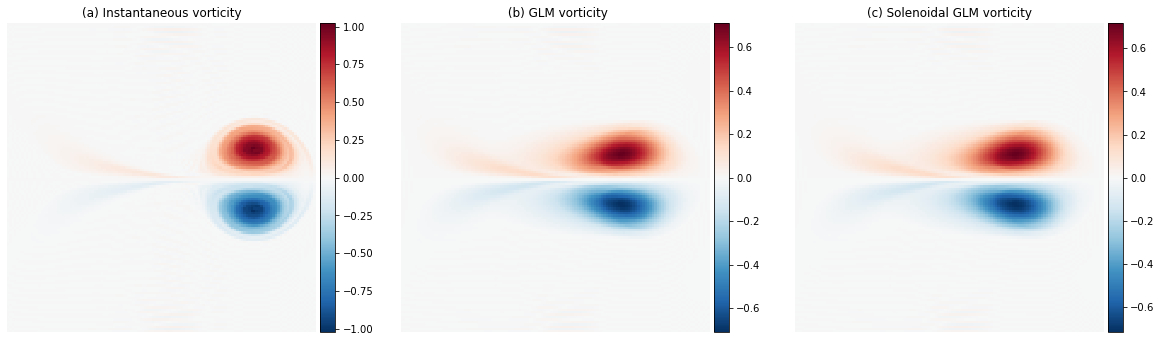

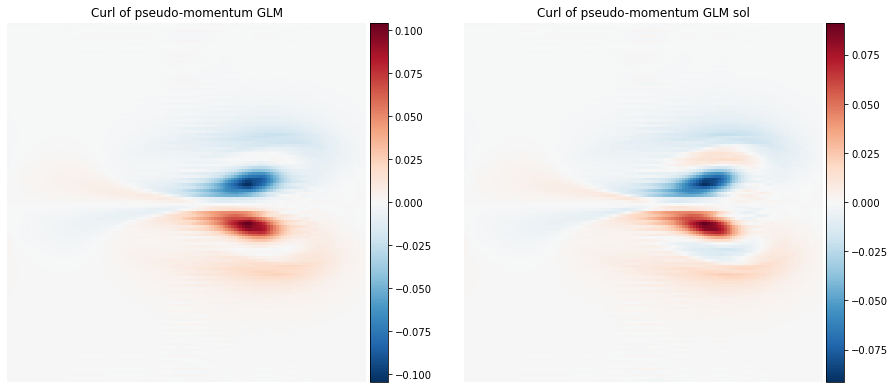

In [7]:
i = 94
fig1, ax1 = plt.subplots(1,3, figsize = (20,10))

im1 = ax1[0].pcolor(xx,yy,zeta[:,:,i], cmap = 'RdBu_r')#, vmin=-.08, vmax=.08)
ax1[0].set_title("(a) Instantaneous vorticity")
ax1[0].set_xlim(0,2*np.pi)
ax1[0].set_ylim(0,2*np.pi)
ax1[0].axis('equal')
ax1[0].axis('off')
divider = make_axes_locatable(ax1[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

im2 = ax1[1].pcolor(xx,yy,zeta1[:,:,i], cmap = 'RdBu_r')#, vmin=-.08, vmax=.08)
ax1[1].set_title(" (b) GLM vorticity")
ax1[1].set_xlim(0,2*np.pi)
ax1[1].set_ylim(0,2*np.pi)
ax1[1].axis('equal')
ax1[1].axis('off')
divider = make_axes_locatable(ax1[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im2, cax=cax)

im3 = ax1[2].pcolor(xx,yy,zeta2[:,:,i], cmap = 'RdBu_r')#, vmin=-.08, vmax=.08)
#im2 = ax1[2].quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_inst/f_mag_inst)[fd::st,fd::st],(v_inst/f_mag_inst)[fd::st,fd::st], pivot = 'middle')
#im2 = ax1[2].streamplot(xx,yy,u_inst,v_inst, density = 1)
ax1[2].set_title("(c) Solenoidal GLM vorticity")
ax1[2].set_xlim(0,2*np.pi)
ax1[2].set_ylim(0,2*np.pi)
ax1[2].axis('equal')
ax1[2].axis('off')
divider = make_axes_locatable(ax1[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax)


fig2, ax2 = plt.subplots(1,2, figsize = (15,15))

im4 = ax2[0].pcolor(xx,yy,c_p, cmap = 'RdBu_r')#, vmin=-.08, vmax=.08)
ax2[0].set_title("Curl of pseudo-momentum GLM")
ax2[0].set_xlim(0,2*np.pi)
ax2[0].set_ylim(0,2*np.pi)
ax2[0].axis('equal')
ax2[0].axis('off')
divider = make_axes_locatable(ax2[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im4, cax=cax)

im5 = ax2[1].pcolor(xx,yy,c_pdivf, cmap = 'RdBu_r')#, vmin=-.08, vmax=.08)
ax2[1].set_title("Curl of pseudo-momentum GLM sol")
ax2[1].set_xlim(0,2*np.pi)
ax2[1].set_ylim(0,2*np.pi)
ax2[1].axis('equal')
ax2[1].axis('off')
divider = make_axes_locatable(ax2[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im5, cax=cax)


plt.show()

## Animations:

In [ ]:
#Animation Instantaneous-Vorticity:
# ++++++++++ plotting the results ++++++++++
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True


fig4, ax4 = plt.subplots()

cax = ax4.pcolormesh(zeta[:-1, :-1, 0], vmin=-.8, vmax=.8, cmap='RdBu_r')
ax4.set_aspect('equal', 'box')
ax4.set_title("Instantaneous-Vorticity")
fig4.colorbar(cax)
plt.close(fig4)



def animate(i):
   cax.set_array(zeta[:-1, :-1, i].flatten())

anim = FuncAnimation(fig4, animate, frames=np.shape(zeta)[2], interval=120)

from IPython.display import HTML
HTML(anim.to_jshtml())

In [ ]:
#Animation Instantaneous-Vorticity:
# ++++++++++ plotting the results ++++++++++
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True


fig4, ax4 = plt.subplots()

cax = ax4.pcolormesh(zeta1[:-1, :-1, 0], vmin=-.8, vmax=.8, cmap='RdBu_r')
ax4.set_aspect('equal', 'box')
ax4.set_title("Instantaneous-Vorticity")
fig4.colorbar(cax)
plt.close(fig4)

def animate(i):
   cax.set_array(zeta1[:-1, :-1, i].flatten())

anim = FuncAnimation(fig4, animate, frames=np.shape(zeta)[2], interval=120)

from IPython.display import HTML
HTML(anim.to_jshtml())

In [ ]:
#Animation Instantaneous-Vorticity:
# ++++++++++ plotting the results ++++++++++
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True


fig4, ax4 = plt.subplots()

cax = ax4.pcolormesh(zeta2[:-1, :-1, 0], vmin=-.8, vmax=.8, cmap='RdBu_r')
ax4.set_aspect('equal', 'box')
ax4.set_title("Instantaneous-Vorticity")
fig4.colorbar(cax)
plt.close(fig4)

def animate(i):
   cax.set_array(zeta2[:-1, :-1, i].flatten())

anim = FuncAnimation(fig4, animate, frames=np.shape(zeta)[2], interval=120)

from IPython.display import HTML
HTML(anim.to_jshtml())

## Instantaneous-Velocity field: 

In [ ]:
#pseudo_xr,pseudo_yr

im_inst = plt.imshow(c_p, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
plt.show()

In [ ]:
u_inst = ur             #Components of velocity
v_inst = vr
f_mag_inst = np.sqrt(u_inst**2 + v_inst**2)
plt.figure(figsize=(6,6))
fd = 20
st = 20
plt.title("Instantaneous-velocity")
ax = plt.subplot()
im_inst = plt.imshow(f_mag_inst, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
plt.quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_inst/f_mag_inst)[fd::st,fd::st],(v_inst/f_mag_inst)[fd::st,fd::st], pivot = 'middle')
plt.streamplot(xx,yy,u_inst,v_inst, density = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_inst,cax)

plt.show()

# LM field

In [ ]:
u_LM = u_LMxr             #Components of velocity
v_LM = u_LMyr
f_mag_LM = np.sqrt(u_LM**2 + v_LM**2)
plt.figure(figsize=(6,6))
fd = 20
st = 20
plt.title("Vorticity with LM-velocity")
ax = plt.subplot()
im_LM = plt.imshow(f_mag_LM, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
plt.quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_LM/f_mag_LM)[fd::st,fd::st],(v_LM/f_mag_LM)[fd::st,fd::st], pivot = 'middle')
plt.streamplot(xx,yy,u_LM,v_LM, density = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_LM,cax)

plt.show()

# DivFree field:

In [ ]:
u_div = udfxr                    #Components of velocity
v_div = udfyr
fd = 20
st = 20
f_mag_div = np.sqrt(u_div**2 + v_div**2)
plt.figure(figsize=(6,6))
ax = plt.subplot()
plt.title("Vorticity with divFree-velocity")
im_div = plt.imshow(f_mag_div, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
plt.quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_div/f_mag_div)[fd::st,fd::st],(v_div/f_mag_div)[fd::st,fd::st], pivot = 'middle')
plt.streamplot(xx,yy,u_div,v_div, density = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_div,cax)

plt.show()

### Plotting the difference of of LM velocity field and div-free velocity field: ($u_{irrot}= \bar{u}^{L} - u_{sol}$)


In [ ]:
#Difference field:
u_LM = u_LMxr                #Components of velocity
v_LM = u_LMyr
u_div = udfxr
v_div = udfyr
#plt.quiver(xx,yy,u,v)
#plt.quiver(al*Xixr,al*Xiyr,u,v)
f_mag = np.sqrt((u_div-u_LM)**2 + (v_div-v_LM)**2)
plt.figure(figsize=(6,6))
fd = 20
st = 20
plt.title("Irrotational field U_irr")
ax = plt.subplot()
im22 = plt.imshow(f_mag, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')
plt.quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_LM/f_mag - u_div/f_mag)[fd::st,fd::st],(v_LM/f_mag - v_div/f_mag)[fd::st,fd::st], pivot = 'middle')
plt.streamplot(xx,yy,u_LM-u_div,v_LM - v_div, density = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im22,cax)

plt.show()

### Comparision for different velocity fields that are obtained above:
---
Here we see stream-plots and quiver plot for the flow fields.

In [ ]:
u_inst = ur                   #Instantaneous components
v_inst = vr
u_LM = u_LMxr                #Components of LM velocity
v_LM = u_LMyr           
u_div = udfxr            #Components of DivFree velocity field:
v_div = udfyr

st= 10
fd= 10

f_mag_div = np.sqrt((u_div)**2 + (v_div)**2)
f_mag_LM = np.sqrt(u_LM**2 + v_LM**2)
f_mag_inst = np.sqrt(u_inst**2 + v_inst**2)
f_mag2 = np.sqrt((u_div-u_LM)**2 + (v_div-v_LM)**2)

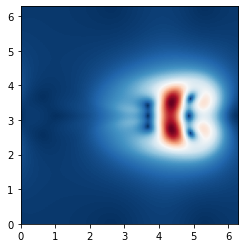

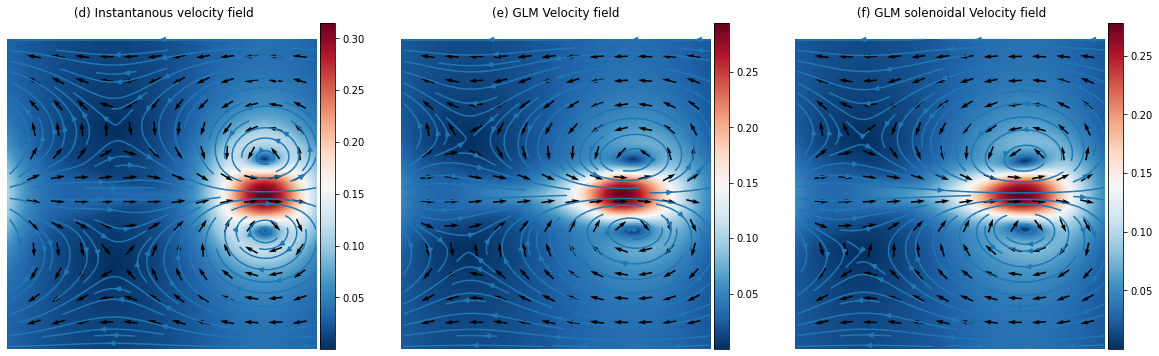

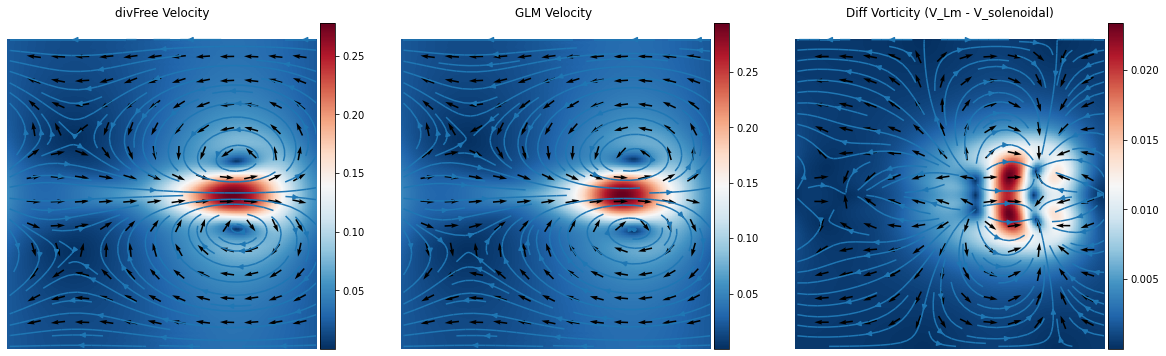

In [8]:
u_inst = ur                   #Instantaneous components
v_inst = vr
u_LM = u_LMxr                #Components of LM velocity
v_LM = u_LMyr           
u_div = udfxr            #Components of DivFree velocity field:
v_div = udfyr

st= 10
fd= 10

f_mag_div = np.sqrt((u_div)**2 + (v_div)**2)
f_mag_LM = np.sqrt(u_LM**2 + v_LM**2)
f_mag_inst = np.sqrt(u_inst**2 + v_inst**2)
f_mag2 = np.sqrt((u_div-u_LM)**2 + (v_div-v_LM)**2)
im_inst = plt.imshow(f_mag_inst, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
im_LM = plt.imshow(f_mag_LM, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
im_div = plt.imshow(f_mag_div, origin = "lower" , extent = (0, 2*np.pi, 0, 2*np.pi),cmap = 'RdBu_r')
im22 = plt.imshow(f_mag2, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')




fig1, ax1 = plt.subplots(1,3, figsize = (20,10))

#DivFree field Plot
im1 = ax1[2].imshow(f_mag_div, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')
im1 = ax1[2].quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_div/f_mag_div)[fd::st,fd::st],(v_div/f_mag_div)[fd::st,fd::st], pivot = 'middle')
im1 = ax1[2].streamplot(xx,yy,u_div, v_div, density = 1)
ax1[2].set_title(" (f) GLM solenoidal Velocity field")
ax1[2].set_xlim(0,2*np.pi)
ax1[2].set_ylim(0,2*np.pi)
ax1[2].axis('equal')
ax1[2].axis('off')
divider = make_axes_locatable(ax1[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_div, cax=cax)

#LM-field plot
im1 = ax1[1].imshow(f_mag_LM, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')
im1 = ax1[1].quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_LM/f_mag_LM)[fd::st,fd::st],(v_LM/f_mag_LM)[fd::st,fd::st], pivot = 'middle')
im1 = ax1[1].streamplot(xx,yy,u_LM,v_LM, density = 1)
ax1[1].set_title("(e) GLM Velocity field")
ax1[1].set_xlim(0,2*np.pi)
ax1[1].set_ylim(0,2*np.pi)
ax1[1].axis('equal')
ax1[1].axis('off')
divider = make_axes_locatable(ax1[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_LM, cax=cax)

#Instantaneous field plot
im1 = ax1[0].imshow(f_mag_inst, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')
im1 = ax1[0].quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_inst/f_mag_inst)[fd::st,fd::st],(v_inst/f_mag_inst)[fd::st,fd::st], pivot = 'middle')
im1 = ax1[0].streamplot(xx,yy,u_inst,v_inst, density = 1)
ax1[0].set_title(" (d) Instantanous velocity field")
ax1[0].set_xlim(0,2*np.pi)
ax1[0].set_ylim(0,2*np.pi)
ax1[0].axis('equal')
ax1[0].axis('off')
divider = make_axes_locatable(ax1[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_inst, cax=cax)



fig2, ax2 = plt.subplots(1,3, figsize = (20,10))

#DivFree field Plot
ima1 = ax2[0].imshow(f_mag_div, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')
ima1 = ax2[0].quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_div/f_mag_div)[fd::st,fd::st],(v_div/f_mag_div)[fd::st,fd::st], pivot = 'middle')
ima1 = ax2[0].streamplot(xx,yy,u_div, v_div, density = 1)
ax2[0].set_title("divFree Velocity")
ax2[0].set_xlim(0,2*np.pi)
ax2[0].set_ylim(0,2*np.pi)
ax2[0].axis('equal')
ax2[0].axis('off')
divider = make_axes_locatable(ax2[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_div, cax=cax)

#LM-field plot
ima1 = ax2[1].imshow(f_mag_LM, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')
ima1 = ax2[1].quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_LM/f_mag_LM)[fd::st,fd::st],(v_LM/f_mag_LM)[fd::st,fd::st], pivot = 'middle')
ima1 = ax2[1].streamplot(xx,yy,u_LM,v_LM, density = 1)
ax2[1].set_title("GLM Velocity ")
ax2[1].set_xlim(0,2*np.pi)
ax2[1].set_ylim(0,2*np.pi)
ax2[1].axis('equal')
ax2[1].axis('off')
divider = make_axes_locatable(ax2[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_LM, cax=cax)


#Irrotational-field plot
im2 = ax2[2].imshow(f_mag2, origin = "lower" , extent = (0, 2*np.pi,0, 2*np.pi),cmap = 'RdBu_r')
im2 = ax2[2].quiver(xx[fd::st,fd::st],yy[fd::st,fd::st],(u_LM/f_mag2 - u_div/f_mag2)[fd::st,fd::st],(v_LM/f_mag2 - v_div/f_mag2)[fd::st,fd::st], pivot = 'middle')
im2 = ax2[2].streamplot(xx,yy,u_LM - u_div,v_LM - v_div, density = 1)
ax2[2].set_title("Diff Vorticity (V_Lm - V_solenoidal)")
ax2[2].set_xlim(0,2*np.pi)
ax2[2].set_ylim(0,2*np.pi)
ax2[2].axis('equal')
ax2[2].axis('off')
divider = make_axes_locatable(ax2[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im22, cax=cax)



plt.show()